In [12]:
import torch
import matplotlib.pyplot as plt
from torchvision.datasets.utils import download_url
import os
import numpy as np
import torchvision

In [13]:
!ls

'EMNIST (MULTI-CLASS).ipynb'


In [14]:
# raw_folder = '../data/EMNIST/raw'
# url = 'https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip'
# md5 = "58c8d27c78d21e728a6bc7b3cc06412e"

# version_numbers = list(map(int, torchvision.__version__.split('+')[0].split('.')))
# if version_numbers[0] == 0 and version_numbers[1] < 10:
#     filename = "emnist.zip"
# else:
#     filename = None

# os.makedirs(raw_folder, exist_ok=True)

# # download files
# print('Downloading zip archive')
# download_url(url, root=raw_folder, filename=filename, md5=md5)

In [15]:
root_dir = "../data" 

dataset = torchvision.datasets.EMNIST(root=root_dir,
                                   split="letters",
                                   train=True,
                                   download=True)

In [16]:
dataset

Dataset EMNIST
    Number of datapoints: 124800
    Root location: ../data
    Split: Train

In [17]:
dataset.classes

['N/A',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [18]:
len(dataset.classes)

27

In [19]:
X = dataset.data
Y = dataset.targets

In [20]:
X.shape, Y.shape

(torch.Size([124800, 28, 28]), torch.Size([124800]))

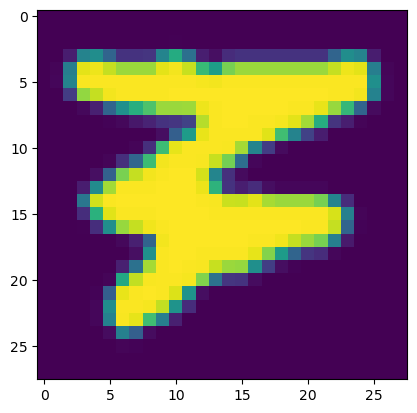

In [21]:
plt.imshow(X[0])

In [22]:
train_size = int(len(dataset) * 0.8)
X_train = X[:train_size] /255
Y_train = Y[:train_size]
Y_train = Y[:train_size].unsqueeze(1)

X_test = X[train_size:] /255
Y_test = Y[train_size:]
Y_test = Y[train_size:].unsqueeze(1)

In [23]:
torch.manual_seed(42)

# n_classes = X_train.shape[1]
n_classes = len(dataset.classes)
alpha = 0.08
losses = []
train_losses = []

input_size = 28 * 28
W = torch.randn(input_size, n_classes, requires_grad=True) * 0.05
b = torch.randn(1, n_classes, requires_grad=True)

In [24]:
W.shape, b.shape, X_train.shape, Y_train.shape

(torch.Size([784, 27]),
 torch.Size([1, 27]),
 torch.Size([99840, 28, 28]),
 torch.Size([99840, 1]))

In [25]:
num_epochs = 400
batch_size = 128

# Set learning rate decay parameters
decay_factor = 0.1
decay_epochs = 10
prev_val_loss = float('inf')
count = 0
val_losses = []

for epoch in range(num_epochs):
    # Shuffle the dataset
    indices = torch.randperm(len(X_train))
    
    for start in range(0, len(X_train), batch_size):
        end = min(start + batch_size, len(X_train))
        batch_indices = indices[start:end]
        
        # Extract batch
        X_batch = X_train[batch_indices]
        Y_batch = Y_train[batch_indices]
        
        # Forward pass
        Z = X_batch.view(-1, input_size) @ W + b
        zmax = Z.max(dim=1, keepdim=True).values
        znorm = Z - zmax
        
        zexp = znorm.exp() 
        zexp_sum = zexp.sum(dim=1, keepdim=True)
        zexp_sum_inv = zexp_sum ** (-1)
        probs = zexp * zexp_sum_inv
        log_probs = probs.log()
        L = -log_probs[torch.arange(len(Y_batch)), Y_batch.squeeze()].mean()
        losses.append(L.item()) # batch loss
        
        # Compute gradients
        dL_dL = torch.ones_like(L)
        dL_dlogprobs = torch.zeros_like(log_probs)
        dL_dlogprobs[torch.arange(len(Y_batch)), Y_batch.squeeze()] = -dL_dL / len(Y_batch)
        dL_dprobs = dL_dlogprobs * 1 / probs
        
        dL_dzexp = dL_dprobs * zexp_sum_inv
        dL_dzexp_sum_inv = (dL_dprobs * zexp).sum(1, keepdim=True)
        dL_dzexp_sum = -1 * dL_dzexp_sum_inv * zexp_sum**(-2)
        dL_dzexp += dL_dzexp_sum
        dL_dznorm = dL_dzexp * zexp.clone()
        
        dL_dzmax = -dL_dznorm.sum(1, keepdim=True)
        dL_dZ = dL_dznorm
        dL_dZ += torch.nn.functional.one_hot(Z.max(dim=1).indices, n_classes) * dL_dzmax
        
        dL_dW = X_batch.view(-1, input_size).T @ dL_dZ
        dL_db = dL_dZ.sum(0, keepdim=True)
        
        # Update parameters using SGD
        with torch.no_grad():
            W -= alpha * dL_dW
            b -= alpha * dL_db
        

    train_loss = np.mean(losses)
    train_losses.append(train_loss)  # Store the epoch training loss
    
    # Perform validation
    with torch.no_grad():
        Z_val = X_test.view(-1, input_size) @ W + b
        loss = -torch.log_softmax(Z_val, dim=1)[torch.arange(len(Y_test)), Y_test.squeeze()].mean()
        val_loss = loss.item()
        if val_loss > prev_val_loss:
            count += 1
        else:
            count = 0
        if count >= decay_epochs:
            alpha *= decay_factor
            count = 0
        prev_val_loss = val_loss
        val_losses.append(val_loss)
    losses.append(L.item())

    if epoch == 0 or (epoch % 10 == 0):
        print(f"Epoch: {epoch}, Loss: {np.mean(losses)}, Learning Rate: {alpha}, val_loss: {val_loss}")

Epoch: 0, Loss: 1.517195063730208, Learning Rate: 0.08, val_loss: 1.234602928161621
Epoch: 10, Loss: 1.1091602220133983, Learning Rate: 0.08, val_loss: 1.0424944162368774
Epoch: 20, Loss: 1.0586269096727525, Learning Rate: 0.08, val_loss: 1.0211420059204102
Epoch: 30, Loss: 1.0343222726155064, Learning Rate: 0.08, val_loss: 1.0134996175765991
Epoch: 40, Loss: 1.0192244860986786, Learning Rate: 0.08, val_loss: 1.0112745761871338
Epoch: 50, Loss: 1.0086767754614367, Learning Rate: 0.08, val_loss: 1.0110417604446411
Epoch: 60, Loss: 1.0007674493331462, Learning Rate: 0.08, val_loss: 1.007611870765686
Epoch: 70, Loss: 0.9945033391728779, Learning Rate: 0.08, val_loss: 1.007245421409607
Epoch: 80, Loss: 0.989401448056771, Learning Rate: 0.08, val_loss: 1.0081082582473755
Epoch: 90, Loss: 0.9851370604064305, Learning Rate: 0.08, val_loss: 1.0072312355041504
Epoch: 100, Loss: 0.9814733244078503, Learning Rate: 0.08, val_loss: 1.0082767009735107
Epoch: 110, Loss: 0.9783067488352425, Learning R

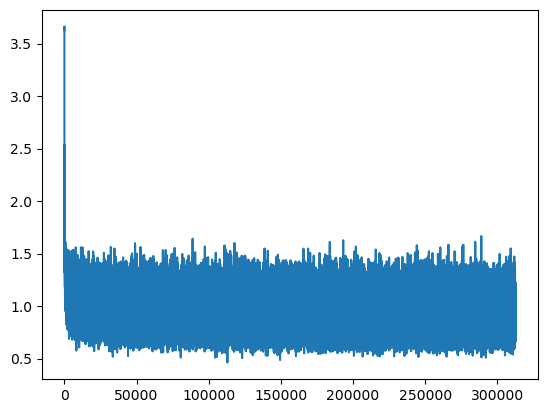

In [26]:
plt.plot(losses)

In [27]:
correct = 0
total = 0

with torch.no_grad():
    for i in range(len(X_test)):
        # Forward pass
        Z = X_test[i].view(1, -1) @ W + b
        predicted_class = torch.argmax(Z, dim=1)

        if predicted_class == Y_test[i]:
            correct += 1
        total += 1
accuracy = correct / total
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.715224358974359


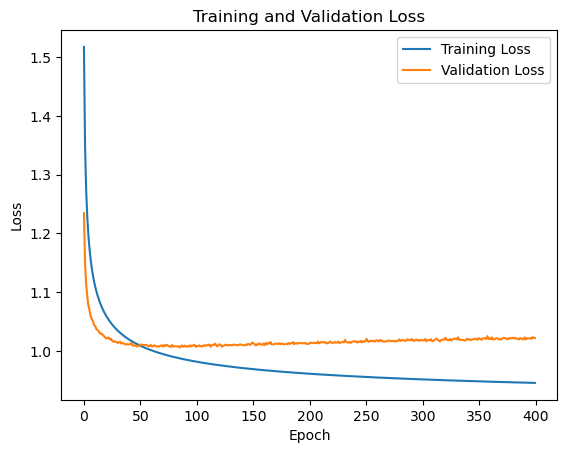

In [28]:
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()